# Pandas Demo Lecture
This notebook walks through beginner → advanced pandas operations with practical, Singapore-flavored examples.

## 0) Setup
Install (if needed) and import pandas & friends.

In [1]:
# If running locally and you don't have the libs:
# %pip install pandas pyarrow openpyxl matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 8)
pd.set_option("display.width", 120)
print(pd.__version__)

2.2.3


## 📊 Dataset Relationships (Star Schema)

```
┌─────────────────────┐
│    CUSTOMERS        │  37 customers (dimension table)
├─────────────────────┤
│ 🔑 customer_id      │────────┐
│ 📍 city             │        │
│ 🏢 segment          │        │
└─────────────────────┘        │
                               │
                               │ LEFT JOIN
                               │ (on customer_id)
                               │
┌─────────────────────┐        │
│    ORDERS           │  195 orders (fact table) ◄──┘
├─────────────────────┤
│ 🔑 customer_id      │
│ 📅 date             │────────┐
│ 🏪 store            │        │
│ 📦 product          │        │
│ 🔢 qty              │        │
│ 💵 price            │        │ LEFT JOIN
│ 🏷️  discount        │        │ (on date, store, product)
│ 💰 revenue          │        │
└─────────────────────┘        │
                               │
┌─────────────────────┐        │
│    SALES            │  531 transactions (base table) ◄──┘
├─────────────────────┤
│ 📅 date             │
│ 🏪 store            │
│ 📦 product          │
│ 🔢 qty              │
│ 💵 price            │
│ 🏷️  discount        │
│ 💰 revenue          │
└─────────────────────┘
```

### 🔗 Join Flow:
1. **SALES** (base) ← **ORDERS** (subset with customer attribution)
2. **ORDERS** ← **CUSTOMERS** (adds demographic/segment data)

### ⚠️ Key Teaching Points:
- **orders** ⊆ **sales** (195 out of 531 transactions have customer_id)
- LEFT JOINs preserve all sales/orders, customer info may be NULL
- Intentional missing data for imputation demonstrations


## 1) Datasets for the session
We'll use three CSVs created for this lecture.

In [2]:
from pathlib import Path
sales_path = Path("data/sales.csv")
cust_path = Path("data/customers.csv")
orders_path = Path("data/orders.csv")
for p in [sales_path, cust_path, orders_path]:
    print("✓ Exists:", p, p.exists())

✓ Exists: data/sales.csv True
✓ Exists: data/customers.csv True
✓ Exists: data/orders.csv True


In [3]:
sales = pd.read_csv(sales_path, parse_dates=["date"])
customers = pd.read_csv(cust_path)
orders = pd.read_csv(orders_path)
display(sales.head(3))
display(customers.head(3))
display(orders.head(3))

,date,store,product,qty,price,discount,revenue
0,2024-01-01,SG-East,Widget,23,20,0.05,437.0
1,2024-01-01,SG-East,Gadget,16,35,0.00,560.0
2,2024-01-01,SG-East,Doohickey,42,12,0.00,504.0


,customer_id,city,segment
0,1001,Woodlands,Consumer
1,1002,Yishun,Corporate
2,1003,Tampines,Consumer


,date,store,product,qty,price,discount,revenue,customer_id
0,2024-01-08,SG-East,Doohickey,38,12,0.05,433.2,1006
1,2024-02-14,SG-North,Widget,27,20,0.10,486.0,1004
2,2024-02-19,SG-West,Gadget,20,35,0.00,700.0,1020


## 2) Inspect, filter, sort, assign

In [4]:
sales.info()
sales.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      531 non-null    datetime64[ns]
 1   store     531 non-null    object        
 2   product   531 non-null    object        
 3   qty       531 non-null    int64         
 4   price     531 non-null    int64         
 5   discount  531 non-null    float64       
 6   revenue   531 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 29.2+ KB


,date,store,product,qty,price,discount,revenue
count,531,531,531,531.000000,531.000000,531.000000,531.000000
unique,NaN,3,3,NaN,NaN,NaN,NaN
top,NaN,SG-East,Widget,NaN,NaN,NaN,NaN
freq,NaN,177,177,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
50%,2024-01-30 00:00:00,NaN,NaN,25.000000,20.000000,0.000000,476.000000
75%,2024-02-15 00:00:00,NaN,NaN,36.000000,35.000000,0.050000,540.000000
max,2024-02-29 00:00:00,NaN,NaN,58.000000,35.000000,0.150000,819.000000
std,NaN,NaN,NaN,11.655919,9.542556,0.046615,106.883902


In [5]:
# Filtering (boolean masks)
high_rev = sales[sales['revenue'] > 600]
display(high_rev.head(3))

# Multiple conditions
east_widget = sales[(sales['store'] == 'SG-East') & (sales['product'] == 'Widget')]
display(east_widget.head(3))

# Sort
display(sales.sort_values(['date','revenue'], ascending=[True, False]).head(3))

# Create/assign new columns
sales = sales.assign(avg_price = lambda df: df['revenue'] / df['qty'])
display(sales.head(3))

,date,store,product,qty,price,discount,revenue
7,2024-01-01,SG-North,Gadget,19,35,0.0,665.0
22,2024-01-03,SG-West,Gadget,20,35,0.0,700.0
38,2024-01-05,SG-East,Doohickey,57,12,0.0,684.0


,date,store,product,qty,price,discount,revenue
0,2024-01-01,SG-East,Widget,23,20,0.05,437.0
9,2024-01-02,SG-East,Widget,19,20,0.10,342.0
18,2024-01-03,SG-East,Widget,19,20,0.00,380.0


,date,store,product,qty,price,discount,revenue
7,2024-01-01,SG-North,Gadget,19,35,0.0,665.0
1,2024-01-01,SG-East,Gadget,16,35,0.0,560.0
2,2024-01-01,SG-East,Doohickey,42,12,0.0,504.0


,date,store,product,qty,price,discount,revenue,avg_price
0,2024-01-01,SG-East,Widget,23,20,0.05,437.0,19.0
1,2024-01-01,SG-East,Gadget,16,35,0.00,560.0,35.0
2,2024-01-01,SG-East,Doohickey,42,12,0.00,504.0,12.0


## 3) Pivot, pivot_table

In [6]:
# pivot: values must be unique per index/columns combo. We'll pre-aggregate first.
daily = sales.groupby(['date','product'], as_index=False)['revenue'].sum()
pv = daily.pivot(index='date', columns='product', values='revenue')
display(pv.head(3))

# pivot_table: can aggregate on the fly and add margins
pt = pd.pivot_table(sales, index='store', columns='product', values='revenue', aggfunc='sum', margins=True, margins_name='Total')
display(pt)

product,Doohickey,Gadget,Widget
date,,,
2024-01-01,1414.8,1680.00,1277.0
2024-01-02,1416.0,1398.25,1162.0
2024-01-03,1350.6,1545.25,1222.0


product,Doohickey,Gadget,Widget,Total
store,,,,
SG-East,27889.2,27399.75,28158.0,83446.95
SG-North,27640.8,30007.25,28774.0,86422.05
SG-West,26677.8,31015.25,27283.0,84976.05
Total,82207.8,88422.25,84215.0,254845.05


## 4) Join/Merge (relational ops)

In [7]:
# orders has a subset of sales rows with customer_id; let's enrich with customer attributes
# First convert orders date column to datetime to match sales
orders['date'] = pd.to_datetime(orders['date'])

print("=== MERGE EXAMPLE WITH MISSING DATA HANDLING ===")
print("Before merge - row counts:")
print(f"Orders: {len(orders)}, Customers: {len(customers)}, Sales: {len(sales)}")

# Left join: keep all orders, add customer info where available
enriched = (orders.merge(customers, on='customer_id', how='left')
                 .merge(sales[['date','store','product','revenue','qty']],
                        on=['date','store','product'], how='left'))

print(f"\nAfter merge: {len(enriched)} rows")
print(f"Missing customer info: {enriched[['city', 'segment']].isnull().sum().sum()} values")
display(enriched.head(3))

# Anti-join example: customers with no orders
ordered_ids = set(enriched['customer_id'].unique())
no_orders = customers[~customers['customer_id'].isin(ordered_ids)]
print(f"\n=== CUSTOMERS WITHOUT ORDERS ===")
print(f"Found {len(no_orders)} customers with no orders:")
if len(no_orders) > 0:
    display(no_orders.head(3))
else:
    print("All customers have at least one order")

=== MERGE EXAMPLE WITH MISSING DATA HANDLING ===
Before merge - row counts:
Orders: 195, Customers: 37, Sales: 531

After merge: 195 rows
Missing customer info: 46 values


,date,store,product,qty_x,price,discount,revenue_x,customer_id,city,segment,revenue_y,qty_y
0,2024-01-08,SG-East,Doohickey,38,12,0.05,433.2,1006,NaN,NaN,433.2,38
1,2024-02-14,SG-North,Widget,27,20,0.10,486.0,1004,Bukit Timah,Consumer,486.0,27
2,2024-02-19,SG-West,Gadget,20,35,0.00,700.0,1020,NaN,NaN,700.0,20



=== CUSTOMERS WITHOUT ORDERS ===
Found 0 customers with no orders:
All customers have at least one order


#### Teaching Tip: Merge Types Visualization

<details>
<summary><b>Visual guide to merge types</b></summary>

```
LEFT JOIN (how='left'):   INNER JOIN (how='inner'):
Orders → [All kept]       Orders → [Only matches]
Customers → [If match]    Customers → [Only matches]

RIGHT JOIN (how='right'): OUTER JOIN (how='outer'):
Orders → [If match]       Orders → [All kept]
Customers → [All kept]    Customers → [All kept]
```

**This Cell:** Uses LEFT join to keep all orders, adding customer info where available.

**Common Issue:** Notice the NaN values in city/segment? That's orders from customers not in our customer table!

**Real-World Lesson:** Always check `.isnull().sum()` after merge - it reveals data quality issues.

</details>

## 5) Window functions: rolling, expanding, ranking

In [8]:
# Rolling 7-day revenue per product
daily_prod = (sales.groupby(['date','product'])['revenue'].sum()
                   .reset_index()
                   .sort_values(['product','date']))
daily_prod['rev_7d'] = (daily_prod.groupby('product')['revenue']
                                     .transform(lambda s: s.rolling(7, min_periods=1).mean()))
display(daily_prod.head(3))

,date,product,revenue,rev_7d
0,2024-01-01,Doohickey,1414.8,1414.8
3,2024-01-02,Doohickey,1416.0,1415.4
6,2024-01-03,Doohickey,1350.6,1393.8


In [9]:
# Ranking top products per day
ranked = (daily_prod.assign(rank=lambda df: df.groupby('date')['revenue'].rank(ascending=False, method='first'))
                    .query('rank <= 2'))
display(ranked.head(3))

,date,product,revenue,rev_7d,rank
0,2024-01-01,Doohickey,1414.8,1414.8,2.0
3,2024-01-02,Doohickey,1416.0,1415.4,1.0
6,2024-01-03,Doohickey,1350.6,1393.8,2.0


## 6) Time series: resample & pd.Grouper

In [10]:
# Weekly revenue per store
weekly = (sales.set_index('date')
               .groupby(['store', pd.Grouper(freq='W')])['revenue']
               .sum()
               .unstack('store'))
display(weekly.head(3))

store,SG-East,SG-North,SG-West
date,,,
2024-01-07,9755.20,9439.55,9841.50
2024-01-14,10108.40,10897.80,10230.35
2024-01-21,9489.05,10137.60,9789.55


## 7) Advanced Missing Data Handling & Imputation Techniques

---

## Missing Data & Imputation

<details>
<summary><b>Click to expand: Section Overview & Learning Objectives</b></summary>

### learning objectives:
1. **Identify** different types of missing data (MCAR, MAR, MNAR)
2. **Apply** appropriate imputation methods based on data characteristics
3. **Analyze** missing data patterns before making decisions
4. **Implement** production-ready data cleaning pipelines
5. **Handle** real-world data quality issues (messy dates, outliers, etc.)

### Key Concepts to Emphasize:
- **Missing data is information** - why it's missing matters
- **No one-size-fits-all** - different methods for different scenarios
- **Always validate** - check if imputed values make business sense
- **Document decisions** - imputation affects downstream analysis

### Common Student Questions:
**Q: "When should I delete rows vs. impute?"**  
A: Delete when >50% missing, not important column, or large dataset. Impute when <20% missing, critical column, or small dataset.

**Q: "Which imputation method is best?"**  
A: Depends on data type, missingness pattern, and downstream use. See comparison tables in the cells below.

**Q: "Won't imputation bias my analysis?"**  
A: Yes! That's why we analyze patterns first. Document assumptions and test sensitivity.

</details>

---

In [11]:
# Create a more realistic dataset with missing values for demonstration
np.random.seed(42)  # For reproducible results

# Start with enriched data and introduce strategic missing values
demo_data = enriched.copy()

# 1. Missing customer data (as we saw in the merge)
print("=== MISSING DATA PATTERNS ===")
print(f"Missing customer cities: {demo_data['city'].isna().sum()}")
print(f"Missing customer segments: {demo_data['segment'].isna().sum()}")

# 2. Create additional missing patterns
# Some revenue might be missing due to system errors
missing_rev_idx = np.random.choice(demo_data.index, size=12, replace=False)
demo_data.loc[missing_rev_idx, 'revenue_x'] = np.nan

# Some quantities might be missing
missing_qty_idx = np.random.choice(demo_data.index, size=8, replace=False)
demo_data.loc[missing_qty_idx, 'qty_x'] = np.nan

# Some discounts might be missing (MNAR - Missing Not At Random)
# Higher revenue items might have missing discount data
high_rev_idx = demo_data[demo_data['revenue_x'] > 600].index
if len(high_rev_idx) > 0:
    missing_disc_idx = np.random.choice(high_rev_idx, size=min(6, len(high_rev_idx)), replace=False)
    demo_data.loc[missing_disc_idx, 'discount'] = np.nan

print(f"\nAfter introducing missing patterns:")
print(demo_data.isnull().sum())
display(demo_data.head(3))

=== MISSING DATA PATTERNS ===
Missing customer cities: 23
Missing customer segments: 23

After introducing missing patterns:
date          0
store         0
product       0
qty_x         8
             ..
city         23
segment      23
revenue_y     0
qty_y         0
Length: 12, dtype: int64


,date,store,product,qty_x,price,discount,revenue_x,customer_id,city,segment,revenue_y,qty_y
0,2024-01-08,SG-East,Doohickey,38.0,12,0.05,433.2,1006,NaN,NaN,433.2,38
1,2024-02-14,SG-North,Widget,27.0,20,0.10,486.0,1004,Bukit Timah,Consumer,486.0,27
2,2024-02-19,SG-West,Gadget,20.0,35,0.00,700.0,1020,NaN,NaN,700.0,20


#### Teaching Point: Understanding Missing Data Patterns

<details>
<summary><b>Click to expand: Key Concepts for This Cell</b></summary>

**Three Types of Missingness:**
1. **MCAR** (Missing Completely at Random) - No pattern, truly random
2. **MAR** (Missing at Random) - Pattern related to observed data
3. **MNAR** (Missing Not at Random) - Pattern related to unobserved data

**In This Example:**
- Customer data missing = **MAR** (related to merge, some customers not in reference table)
- Random revenue/qty missing = **MCAR** (introduced randomly for demo)
- High-value items missing discount = **MNAR** (missingness depends on the value itself)

**Why This Matters:**
Different types require different imputation strategies!

</details>

In [12]:
# === IMPUTATION STRATEGIES ===

print("=== 1. SIMPLE IMPUTATION METHODS ===")

# Strategy 1: Forward Fill & Backward Fill (good for time series)
demo_data_sorted = demo_data.sort_values(['date', 'store'])
demo_data['qty_ffill'] = demo_data_sorted.groupby('store')['qty_x'].ffill()
demo_data['qty_bfill'] = demo_data_sorted.groupby('store')['qty_x'].bfill()

# Strategy 2: Mean/Median imputation by group
demo_data['revenue_mean_by_store'] = demo_data.groupby('store')['revenue_x'].transform(
    lambda x: x.fillna(x.mean())
)
demo_data['qty_median_by_product'] = demo_data.groupby('product')['qty_x'].transform(
    lambda x: x.fillna(x.median())
)

# Strategy 3: Mode imputation for categorical
mode_segment = demo_data.groupby('city')['segment'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Consumer')
demo_data['segment_imputed'] = demo_data.apply(
    lambda row: mode_segment.get(row['city'], 'Consumer') if pd.isna(row['segment']) else row['segment'], 
    axis=1
)

print("Sample of imputed data:")
cols_to_show = ['date', 'store', 'product', 'qty_x', 'qty_median_by_product', 'revenue_x', 'revenue_mean_by_store', 'segment', 'segment_imputed']
display(demo_data[cols_to_show].head(3))

=== 1. SIMPLE IMPUTATION METHODS ===
Sample of imputed data:


,date,store,product,qty_x,qty_median_by_product,revenue_x,revenue_mean_by_store,segment,segment_imputed
0,2024-01-08,SG-East,Doohickey,38.0,38.0,433.2,433.2,NaN,Consumer
1,2024-02-14,SG-North,Widget,27.0,27.0,486.0,486.0,Consumer,Consumer
2,2024-02-19,SG-West,Gadget,20.0,20.0,700.0,700.0,NaN,Consumer


#### Teaching Point: Simple Imputation Strategies

<details>
<summary><b>Click to expand: When to Use Each Method</b></summary>

**Method Selection Guide:**

| Method | Best For | Pandas Code | Pros | Cons |
|--------|----------|-------------|------|------|
| **Mean** | Normal distributions | `.fillna(df['col'].mean())` | Simple | Sensitive to outliers |
| **Median** | Skewed data | `.fillna(df['col'].median())` | Robust | Ignores distribution |
| **Mode** | Categorical | `.fillna(df['col'].mode()[0])` | Preserves common | Arbitrary if multimodal |
| **Forward Fill** | Time series | `.ffill()` | Maintains continuity | Propagates errors |
| **Backward Fill** | Time series | `.bfill()` | Fills from future | Assumes future known |
| **Group-based** | Data with groups | `.groupby('group')['col'].transform(lambda x: x.fillna(x.mean()))` | Context-aware | Needs good grouping |

**Interactive Question for Students:**  
"Which method would you use for customer age? For product category? For daily sales?"

</details>

#### Teaching Point: Advanced Imputation Methods

<details>
<summary><b>Click to expand: Interpolation vs KNN Approaches</b></summary>

**Linear Interpolation:**
- Assumes smooth transitions between known values
- Best for: Time series, ordered data with trends
- Example: Daily temperature, stock prices
- Limitation: Can't extrapolate beyond data range

**KNN-Style Imputation:**
- Finds similar records and uses their values
- Best for: Complex patterns, non-ordered data
- Example: Customer demographics, product features
- Limitation: Computationally expensive for large datasets

**Comparison Table Insight:**
Notice how different methods give different results. In production:
1. Test multiple methods
2. Validate against business logic
3. Document which method was chosen and why

**Discussion Prompt:**  
"Look at the comparison - why do KNN and Mean_by_Store differ? Which would you trust more?"

</details>

In [13]:
print("=== 2. ADVANCED IMPUTATION METHODS ===")

# Strategy 4: Linear Interpolation (for time series data)
# We'll work with a simpler approach for time series interpolation
demo_sorted = demo_data.sort_values(['store', 'product', 'date']).copy()
demo_sorted['revenue_interpolated'] = demo_sorted.groupby(['store', 'product'])['revenue_x'].transform(
    lambda x: x.interpolate(method='linear')
)

# Strategy 5: K-Nearest Neighbors style imputation (manual implementation)
def knn_impute_revenue(df, k=3):
    """Simple KNN imputation based on similar store/product combinations"""
    result = df.copy()
    missing_mask = df['revenue_x'].isna()
    
    print(f"Imputing {missing_mask.sum()} missing revenue values...")
    
    for idx in df[missing_mask].index:
        row = df.loc[idx]
        # Find similar rows (same store and product)
        similar_mask = (df['store'] == row['store']) & (df['product'] == row['product']) & (~df['revenue_x'].isna())
        
        if similar_mask.sum() >= k:
            similar_revenues = df[similar_mask]['revenue_x'].head(k)
            result.loc[idx, 'revenue_x'] = similar_revenues.mean()
        else:
            # Fallback to product mean
            product_mean = df[df['product'] == row['product']]['revenue_x'].mean()
            if pd.notna(product_mean):
                result.loc[idx, 'revenue_x'] = product_mean
    
    return result

demo_knn = knn_impute_revenue(demo_data.copy())

print("\nComparison of imputation methods for revenue (first 15 rows):")
comparison = pd.DataFrame({
    'Original': demo_data['revenue_x'],
    'Mean_by_Store': demo_data['revenue_mean_by_store'],
    'KNN_Style': demo_knn['revenue_x']
})

# Show the differences where there were missing values
missing_rows = demo_data['revenue_x'].isna()
if missing_rows.any():
    print(f"\nFocus on {missing_rows.sum()} rows that had missing revenue:")
    display(comparison[missing_rows].head(3))
else:
    print("Sample comparison:")
    display(comparison.head(3))

=== 2. ADVANCED IMPUTATION METHODS ===
Imputing 12 missing revenue values...

Comparison of imputation methods for revenue (first 15 rows):

Focus on 12 rows that had missing revenue:


,Original,Mean_by_Store,KNN_Style
15,NaN,489.939683,424.600000
16,NaN,483.210769,474.600000
18,NaN,441.694545,447.333333


In [14]:
print("=== 3. MISSING DATA ANALYSIS & VISUALIZATION ===")

# Missing data patterns analysis
def analyze_missing_patterns(df):
    """Analyze patterns in missing data"""
    missing_data = df.isnull()
    
    # Missing data summary
    missing_summary = pd.DataFrame({
        'Column': missing_data.columns,
        'Missing_Count': missing_data.sum(),
        'Missing_Percentage': (missing_data.sum() / len(df)) * 100
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    # Missing data combinations
    if missing_summary.shape[0] > 1:
        missing_patterns = missing_data.groupby(list(missing_data.columns)).size().reset_index().rename(columns={0: 'Count'})
        missing_patterns = missing_patterns[missing_patterns['Count'] > 0]
    else:
        missing_patterns = pd.DataFrame()
    
    return missing_summary, missing_patterns

missing_summary, missing_patterns = analyze_missing_patterns(demo_data)

print("Missing Data Summary:")
display(missing_summary)

# Correlation between missing values
numeric_cols = ['qty_x', 'revenue_x', 'discount', 'price']
missing_corr = demo_data[numeric_cols].isnull().corr()
print("\nCorrelation between missing values:")
display(missing_corr.round(3))

# Check if missingness is random
print("\n=== TESTING FOR RANDOMNESS ===")
# Example: Are high-value transactions more likely to have missing discount data?
demo_data['high_value'] = demo_data['revenue_x'] > 600
contingency = pd.crosstab(demo_data['high_value'], demo_data['discount'].isnull(), margins=True)
print("High value vs Missing discount:")
display(contingency)

=== 3. MISSING DATA ANALYSIS & VISUALIZATION ===
Missing Data Summary:


,Column,Missing_Count,Missing_Percentage
segment,segment,23,11.794872
city,city,23,11.794872
revenue_x,revenue_x,12,6.153846
qty_x,qty_x,8,4.102564
discount,discount,6,3.076923
qty_bfill,qty_bfill,1,0.512821



Correlation between missing values:


,qty_x,revenue_x,discount,price
qty_x,1.000,-0.053,-0.037,NaN
revenue_x,-0.053,1.000,-0.046,NaN
discount,-0.037,-0.046,1.000,NaN
price,NaN,NaN,NaN,NaN



=== TESTING FOR RANDOMNESS ===
High value vs Missing discount:


discount,False,True,All
high_value,,,
False,177,0,177
True,12,6,18
All,189,6,195


#### Missing Data Analysis

<details>
<summary><b>Click to expand: Detective Work Before Imputation</b></summary>

**Always Analyze Before Imputing!**

**The Three Questions:**
1. **How much is missing?** (Percentage matters)
   - <5%: Safe to impute most ways
   - 5-20%: Be careful, document method
   - >20%: Consider if column is useful

2. **Is missingness correlated?** (Check the correlation matrix)
   - High correlation = systematic data collection issue
   - Example: If `price` missing → `revenue` also missing
   - Action: Fix data collection process!

3. **Is it random or systematic?** (Use crosstabs/contingency tables)
   - Example: High-value items missing discount data = MNAR
   - Action: Need domain knowledge to impute correctly

**Real-World Story to Share:**
"In production, we once found that missing customer emails correlated with high-value purchases. Turns out, VIP customers were entered manually and staff often skipped email. We couldn't just impute 'unknown@email.com' - we needed a VIP flag!"

</details>

In [15]:
print("=== 4. PRACTICAL IMPUTATION PIPELINE ===")

def create_imputation_pipeline(df):
    """Complete imputation pipeline for the sales dataset"""
    result = df.copy()
    
    # Step 1: Handle categorical missing values first
    # City imputation: use most common city for that customer_id if available
    customer_city_map = result.groupby('customer_id')['city'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    result['city'] = result.apply(
        lambda row: customer_city_map.get(row['customer_id']) if pd.isna(row['city']) else row['city'],
        axis=1
    )
    
    # Remaining missing cities: use most common overall
    if result['city'].isna().any():
        most_common_city = result['city'].mode().iloc[0]
        result['city'] = result['city'].fillna(most_common_city)
    
    # Segment imputation: use mode by city
    city_segment_mode = result.groupby('city')['segment'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Consumer')
    result['segment'] = result.apply(
        lambda row: city_segment_mode.get(row['city'], 'Consumer') if pd.isna(row['segment']) else row['segment'],
        axis=1
    )
    
    # Step 2: Handle numerical missing values
    # Revenue: use median by store and product combination
    result['revenue_x'] = result.groupby(['store', 'product'])['revenue_x'].transform(
        lambda x: x.fillna(x.median()) if x.notna().sum() > 0 else x.fillna(x.median())
    )
    
    # If still missing, use overall product median
    result['revenue_x'] = result.groupby('product')['revenue_x'].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Quantity: use median by product
    result['qty_x'] = result.groupby('product')['qty_x'].transform(
        lambda x: x.fillna(x.median())
    )
    
    # Discount: use mean by product (since discounts are strategic)
    result['discount'] = result.groupby('product')['discount'].transform(
        lambda x: x.fillna(x.mean())
    )
    
    return result

# Apply the pipeline
cleaned_data = create_imputation_pipeline(demo_data)

print("Before and after imputation:")
before_after = pd.DataFrame({
    'Before': demo_data.isnull().sum(),
    'After': cleaned_data.isnull().sum()
})
display(before_after[before_after['Before'] > 0])

print("\nSample of cleaned data:")
display(cleaned_data[['date', 'store', 'product', 'city', 'segment', 'revenue_x', 'qty_x', 'discount']].head(3))

=== 4. PRACTICAL IMPUTATION PIPELINE ===
Before and after imputation:


,Before,After
qty_x,8,0
discount,6,0
revenue_x,12,0
city,23,0
segment,23,0
qty_bfill,1,1



Sample of cleaned data:


,date,store,product,city,segment,revenue_x,qty_x,discount
0,2024-01-08,SG-East,Doohickey,Jurong,Consumer,433.2,38.0,0.05
1,2024-02-14,SG-North,Widget,Bukit Timah,Consumer,486.0,27.0,0.10
2,2024-02-19,SG-West,Gadget,Jurong,Consumer,700.0,20.0,0.00


#### Teaching Point: Production-Ready Pipeline

<details>
<summary><b>Click to expand: Building Robust Data Cleaning</b></summary>

**What Makes This "Production-Ready"?**

1. **Hierarchical Fallbacks:**
   - Try group-specific imputation first
   - Fall back to broader groups if needed
   - Ultimate fallback: overall statistics

2. **Type-Aware Processing:**
   - Handles categorical separately from numerical
   - Uses appropriate methods for each type
   - Preserves data integrity

3. **Validation Built-In:**
   - Before/after comparison
   - Explicit reporting of what changed
   - Easy to audit

**Code Structure Students Can Reuse:**
```python
def clean_pipeline(df):
    # 1. Handle categorical first
    # 2. Handle numerical with fallbacks
    # 3. Validate results
    # 4. Document changes
    return cleaned_df
```

**Homework Suggestion:**  
"Take this pipeline and adapt it for your own dataset. What modifications do you need?"

**Common Pitfalls to Mention:**
- ❌ Imputing before exploring
- ❌ Using same method for all columns
- ❌ Not documenting imputation decisions
- ❌ Not validating business logic

</details>

### Key Takeaways: Missing Data & Imputation
**Best Practices:**
1. **Always analyze** missing data patterns before imputing (MAR, MCAR, MNAR)
2. **Simple methods** (mean/median) work well for small amounts of missing data
3. **Group-based imputation** preserves data structure better than global methods
4. **Forward/backward fill** ideal for time series with temporal dependencies
5. **Interpolation** works well for ordered data with smooth trends
6. **Document your strategy** - imputation affects downstream analysis
7. **Handle outliers** before imputation to avoid biasing fill values
8. **Validate** - check if imputed values make business sense

#### Teaching Tip: GroupBy is SQL's GROUP BY in Python

<details>
<summary><b>Analogy for students with SQL background</b></summary>

```sql
-- SQL Version
SELECT product, 
       SUM(qty) as qty_total,
       SUM(revenue) as rev_total,
       AVG(discount) as avg_discount
FROM sales
GROUP BY product;
```

```python
# Pandas Version (this cell!)
sales.groupby('product').agg(
    qty_total=('qty','sum'),
    rev_total=('revenue','sum'),
    avg_discount=('discount','mean')
)
```

**Key Point:** Pandas is more flexible - you can use custom functions, chain operations, and avoid SQL string parsing!

</details>

## 9) Plotting with matplotlib (quick looks)

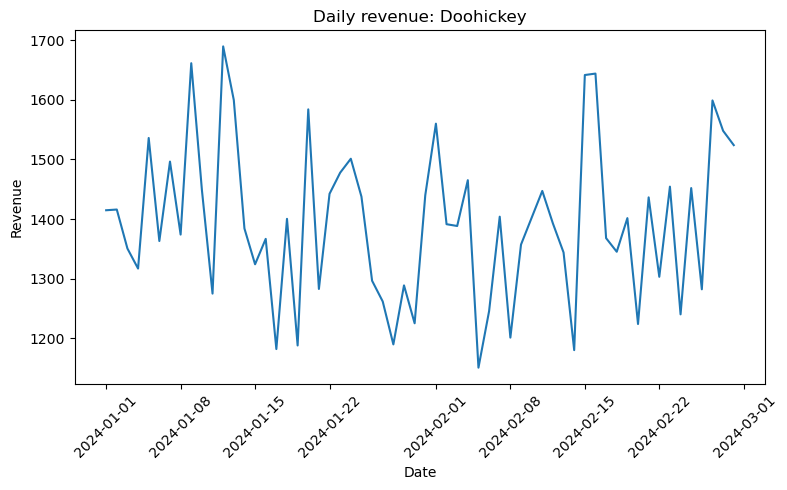

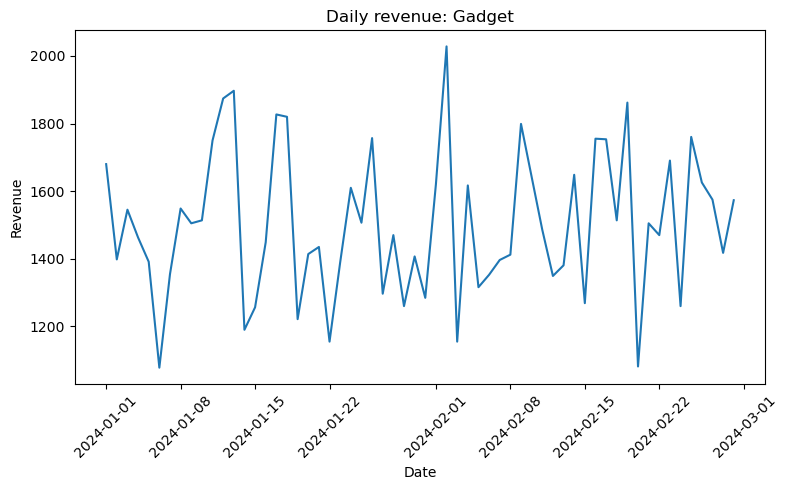

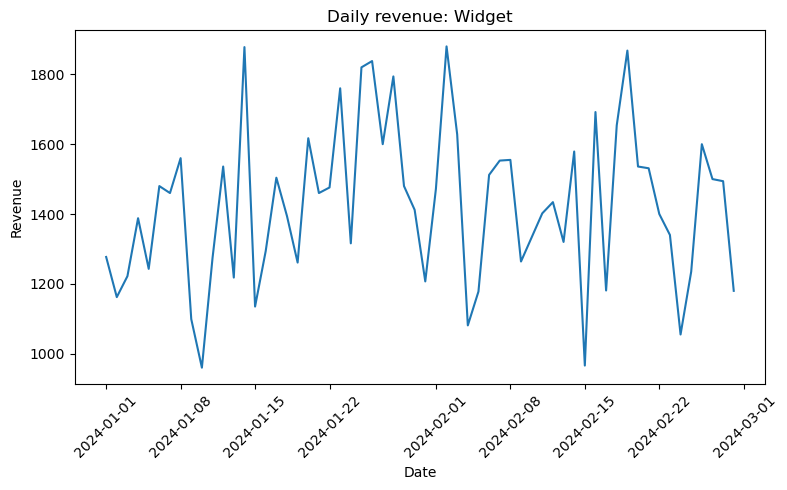

In [16]:
# Sales trend by product
daily_sum = sales.groupby(['date','product'])['revenue'].sum().reset_index()
for prod in daily_sum['product'].unique():
    subset = daily_sum[daily_sum['product'] == prod]
    plt.figure(figsize=(8, 5))
    plt.plot(subset['date'], subset['revenue'])
    plt.title(f'Daily revenue: {prod}')
    plt.xlabel('Date'); plt.ylabel('Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 10) I/O: CSV, Excel, Parquet

In [17]:
# CSV
sales.to_csv('data/sales_out.csv', index=False)
print('Wrote data/sales_out.csv')

# Excel with multiple sheets
with pd.ExcelWriter('data/report.xlsx', engine='openpyxl') as xl:
    sales.head(200).to_excel(xl, sheet_name='sales_sample', index=False)
    customers.to_excel(xl, sheet_name='customers', index=False)
print('Wrote data/report.xlsx')

# Parquet (needs pyarrow or fastparquet)
sales.to_parquet('data/sales.parquet', index=False)
print('Wrote data/sales.parquet')

Wrote data/sales_out.csv
Wrote data/report.xlsx
Wrote data/sales.parquet


## 11) Mini-exercises (for the audience)

1. Find the top-2 products by **weekly revenue** per store.  
2. Compute **month-to-date cumulative revenue** per product.  
3. Using `pivot_table`, show revenue by store×product with **average discount** as values.  
4. From `customers`, turn `segment` into **one-hot columns**, then join to `enriched`.  
5. Create a **90th percentile** daily revenue metric per product and compare across stores.

## End of Lecture - Final Thoughts

### What We Covered Today:

✅ **Basic Operations** (Sections 1-2): Filter, sort, assign  
✅ **Pivot** (Section 3): Data transformation  
✅ **Merging** (Section 4): Combining datasets  
✅ **Window Functions** (Section 5): Rolling calculations  
✅ **Time Series** (Section 6): Date-based operations  
✅ **Missing Data** (Section 7): Complete imputation toolkit - IMPUTATION, DATA QUALITY
✅ **Aggregations** (Section 8): GroupBy operations  
✅ **Visualization** (Section 9): Quick plotting  
✅ **I/O Operations** (Section 10): Reading/writing files  
✅ **Mini-Exercises** (Section 11): Practice problems

### Feedback & Questions:

Feel free to reach out if you have questions about any section. Happy data wrangling!

debdeeppaul001@suss.edu.sg
---
